In [1]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

%matplotlib inline

Using TensorFlow backend.


## 1. Data prepartion

In [6]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [9]:
# define input sequence
raw_seq = series1.to_list()
# choose a number of time steps
n_steps_in, n_steps_out = 12, 6
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

## 2 Encoder-decoder Modeling

In [11]:
# define model
encoder_decoder_model = Sequential()
encoder_decoder_model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
encoder_decoder_model.add(RepeatVector(n_steps_out))
encoder_decoder_model.add(LSTM(100, activation='relu', return_sequences=True))
encoder_decoder_model.add(TimeDistributed(Dense(1)))
encoder_decoder_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# fit model
encoder_decoder_model.fit(X, y, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
17598/17598 [==============================] - 15s 842us/step - loss: 12.4707
Epoch 2/20
17598/17598 [==============================] - 13s 725us/step - loss: 2.5758
Epoch 3/20
17598/17598 [==============================] - 13s 764us/step - loss: 2.2277
Epoch 4/20
17598/17598 [==============================] - 12s 679us/step - loss: 2.1392
Epoch 5/20
17598/17598 [==============================] - 12s 698us/step - loss: 2.3791
Epoch 6/20
17598/17598 [==============================] - 12s 709us/step - loss: 1.9897
Epoch 7/20
17598/17598 [==============================] - 12s 690us/step - loss: 1.9176
Epoch 8/20
17598/17598 [==============================] - 12s 706us/step - loss: 1.8569
Epoch 9/20
17598/17598 [==============================] - 12s 707us/step - loss: 1.8100
Epoch 10/20
17598/17598 [==============================] - 12s 695us/step - loss: 1.8017
Epoch 11/20
17598/17598 [==============================] - 12s 703us/s

## 3. Compute anomaly scores

In [14]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = model.predict(X[i].reshape(1,n_steps_in,n_features))
        score = np.sum(abs(yhat[0]-y[i]))
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(encoder_decoder_model, X, y)

In [15]:
padding_scores = [0.0 for i in range(n_steps_in)] + scores + [0.0 for i in range(n_steps_out-1)]
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb2e648f98>,
      dtype=object)

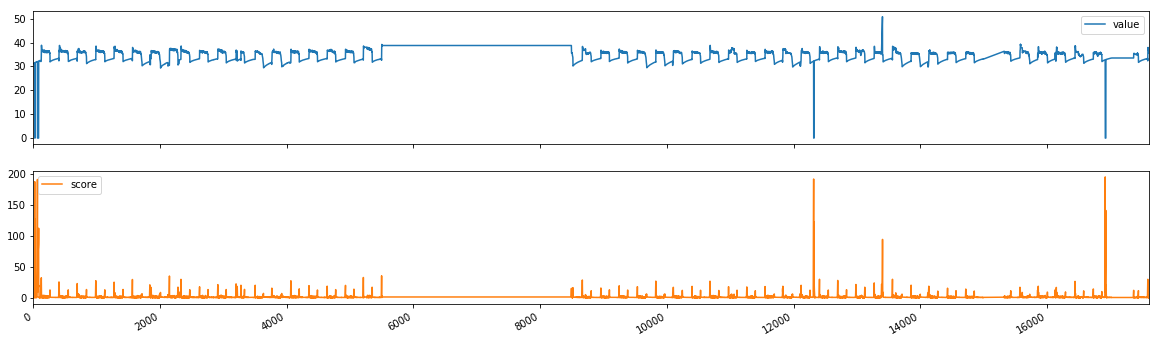

In [16]:
result.plot(figsize=[20,6], subplots=True)